# Predicción de mutaciones cancerosas a partir de imágenes de células humanas

## Metas

En este caso, aprenderá sobre un tipo particular de arquitectura de red neuronal, la **red neuronal convolucional**, que puede manejar datos más complejos, como imágenes. Aprenderá no solo la estructura de este tipo de modelo, sino también cómo entrenarlo y evaluarlo utilizando una caja de herramientas de ciencia de datos moderna. También podrá evaluar las fortalezas y limitaciones de su CNN en comparación con modelos más simples y adquirir experiencia con TensorFlow y Keras.

$$\color{red}{\textbf{Correr en mi compu en Kernel 3.9.1}}$$

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install tensorflow

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\david\appdata\local\programs\python\python39\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [2]:
### Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# general
from numpy import mean
from numpy import std
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# image processing
from PIL import (
    Image,
)  # <-- 
import pickle  # <-- opcionalees para el image processing
import glob
import os
# convolutional neural network -- CNN
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# random forest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("ggplot")

## Introduccion

<img src=files/hook.jpg width="500">

**Contexto empresarial.** Trabaja para un grupo de investigación médica que trabaja para desarrollar un método de diagnóstico que identifica la **predisposición al cáncer** de una persona basándose en imágenes de células humanas.

Esta herramienta podría ser revolucionaria para identificar mutaciones específicas en el gen p53 asociado con el cáncer sin pruebas genéticas; el procedimiento podría ser mucho más económico y menos invasivo. Además, si entendemos qué características de las imágenes se utilizan para distinguir las células mutantes, esto podría ayudar a generar más hipótesis y experimentos sobre las diferencias biológicas subyacentes para ayudar a determinar la predisposición de una persona.

Hay tres tipos diferentes de mutaciones que desea poder detectar, en función de cientos de imágenes de células fotografiadas bajo un microscopio. También debe poder detectar si existe una mutación.

**Problema empresarial.** Se te ha encomendado **predecir la mutación de una célula, dada la información que puedas obtener de estas fotografías**. Específicamente, utilizará imágenes sin procesar de células de fibroblastos humanos y características extraídas de estas imágenes mediante algoritmos de procesamiento de imágenes.

**Contexto analítico.**  En este caso, trabajarenis con datos de imágenes y aprenderá sobre redes neuronales más avanzadas: en particular, la **red neuronal convolucional** (CNN). Practicará el uso y la comparación de una variedad de clasificadores de aprendizaje automático, tanto tradicionales como más modernos, para abordar la pregunta: *¿Podemos predecir mutaciones cancerosas a partir de imágenes de células humanas?*

El caso está estructurado de la siguiente manera: (1) comprenderemos el conjunto de datos de imágenes sin procesar; (2) construiremos, entrenaremos y evaluaremos una CNN simple desde cero; (3) construirá, entrenará y evaluará una CNN más compleja usando el módulo `keras` de TensorFlow; y (4) construirá, entrenará y evaluará un clasificador de aprendizaje automático más tradicional (bosque aleatorio) en un conjunto de características extraídas previamente de las imágenes sin procesar.

<img src=files/cellimage.jpg width="500">

En la imagen de arriba, puedes ver una fotografía de células de fibroblastos de pulmón humano bajo un microscopio. El verde es el cuerpo (el citoplasma) de la célula y el rosa es el núcleo. La biotecnología ha avanzado tanto que podemos realmente "colorear" las células y fotografiarlas con microscopios de alta definición. También podemos hacer esto a gran escala, fotografiando miles de células a la vez. Hoy en día, los científicos pueden incluso colorear diferentes partes de una célula (como el núcleo de arriba, pero también otros orgánulos) haciendo que diferentes proteínas se iluminen con fotofluorescencia. Como en muchas otras industrias, esto ha llevado a una explosión de datos, porque ahora cada celda tiene innumerables características que podemos observar en una sola imagen.

Lo que exploraremos en este caso es cómo trabajar con estos datos de imagen. Sin embargo, muchos de los desafíos que enfrentaremos en este caso no son exclusivos del problema de comprender las celdas: son útiles si alguna vez necesita trabajar con datos de imágenes.

## Entendiendo la data

### Preprocesando las imagenes

Echemos un vistazo a un ejemplo de una imagen sin procesar de cada clase en escala de grises (originalmente estaban en color). 
- La primera imagen es de una célula con la primera mutación (las fotografías de las células se mejoran para refinar los bordes y reducir la borrosidad). 
- La siguiente imagen es un ejemplo de una célula con la segunda mutación. 
- Luego hay un ejemplo de una célula con la tercera mutación, que es más débil porque proviene de un laboratorio que no realiza mejoras de imágenes. 
- Finalmente, hay un ejemplo de una célula donde no hay mutaciones. Estas muestras provienen de un laboratorio donde un técnico rodea manualmente los bordes de las celdas.

Podemos usar [plt.subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) para mostrar multiples imagenes.

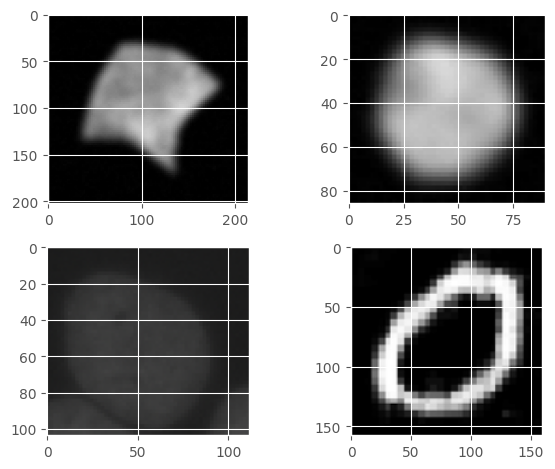

In [3]:
sample_images_path = "sample_images/"
sample_images_list = ["mut_1", "mut_2", "mut_3", "normal"]
for i, img in zip(range(len(sample_images_list)), sample_images_list):
    pil_im = Image.open(sample_images_path + img + ".png", "r")
    # plot raw pixel data,
    plt.subplot(2, 2, 1 + i)
    plt.imshow(np.asarray(pil_im), cmap="Greys")
plt.tight_layout()
plt.show()

En aras del tiempo, trabajaremos con un conjunto de datos preprocesado de las imágenes. El siguiente bloque de código muestra algunas de las transformaciones que se realizaron en los archivos PNG sin procesar. Como esto ya se ejecutó, no necesita ejecutar este código nuevamente, y está "bloqueado" detrás de una declaración `if False`.

Tenga en cuenta que cambiamos el tamaño, centramos y escalamos las imágenes y también ajustamos algunas diferencias de contraste, pero no ajustamos el desenfoque. Trate de pensar en cuáles podrían ser las implicaciones de algunas de estas decisiones:


In [4]:
data_path = "./sample_images/"
imagen= Image.open(data_path+ 'mut_1.png')
w,h=imagen.size
print(w,h)

214 202


In [7]:
## funcion para resize de imagenes, preservando el aspect ratio
run_preprocessing = False
if run_preprocessing:
    def resizeAspect(im, size):
        w, h = im.size
        aspect = max(size[0] / float(w), size[1] / float(h))
        return im.resize((int(w * aspect), int(h * aspect)), Image.ANTIALIAS)

    data_path = "raw_images/"
    imgList = glob.glob(data_path + "*.png")  # find all png images in a directory

    num = 0
    for img in imgList:  # loop through all found images
        im = Image.open(img)  # open the image
        print("resizing:", os.path.basename(img))
        w, h = im.size  # get image width and height
        if min(w, h) > 28:  # check if either dimension is greater then 50
            im = resizeAspect(im, (28, 28))  # re-size image
            w, h = im.size  # update image size
        center = [int(w / 2.0), int(h / 2.0)]  # calculate center
        box = (
            center[0] - 14,
            center[1] - 14,
            center[0] + 14,
            center[1] + 14,
        )  # defines a box where you want it to be cropped
        croppedIm = im.crop(box)  # crop the image
        # croppedIm.show()                           # show the cropped image
        print(croppedIm.size)
        fileName, fileExtension = os.path.splitext(img)
        croppedIm.save(
            "images/" + fileName[len(data_path) :] + "_crop.png", "PNG"
        )  # save the cropped image

### Images en CSV 

Una vez que se completa todo el preprocesamiento, podemos cargar nuestros datos de imagen a través de un archivo CSV y echar un vistazo a nuestras imágenes ajustadas. Todas las dimensiones son iguales y se han corregido algunas de las diferencias de contraste.

Si está acostumbrado a manejar imágenes como archivos individuales (por ejemplo, archivos `.png`), puede parecer extraño pensar en almacenar imágenes en un archivo `.csv`. Sin embargo, el concepto detrás de esto es simple. Cada una de nuestras imágenes se compone de 28x28 píxeles, que son 784 píxeles en total. Cada imagen en `data/all_dat.csv` está representada por una fila con 785 columnas
   
La primera columna es la etiqueta de clasificación de cada imagen. Específicamente, es `0` para células "normales" y `1`, `2` o `3` para los tipos de mutación 1, 2 y 3 respectivamente. Las siguientes 784 columnas representan el valor de escala de grises (los valores más bajos son más oscuros) de cada píxel. Por lo tanto, tenemos 1200 muestras (filas) con 784 columnas cada una.

In [5]:
# Miremos nuestra data
all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))

# La primera columna es la etiqueta
all_imgs = np.asfarray(all_dat[:, 1:])
all_labels = np.asfarray(all_dat[:, :1])

print(all_imgs.shape)
print(all_labels.shape)

(1200, 784)
(1200, 1)


In [6]:
# Miremos unas muestras
pd.DataFrame(all_imgs).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
1,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
2,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
3,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
4,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922


In [7]:
28*28

784

In [17]:
X=pd.DataFrame(all_labels)
X.value_counts()

0.0    300
1.0    300
2.0    300
3.0    300
Name: count, dtype: int64

### Graficando imagenes desde el CSV file 

Debido a que cada imagen se almacena en una sola fila, si realmente queremos verlas como imágenes en lugar de texto, debemos "reformarlas" en una matriz 2D de 28x28 y especificar que se definen como píxeles en escala de grises.
    
Un ejemplo de visualización de una sola imagen es el siguiente:

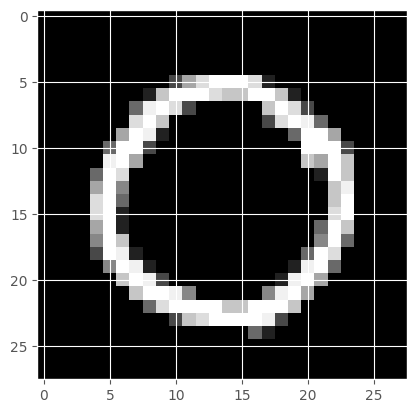

In [21]:
# reshape a 28x28 pixels
img = all_imgs[105].reshape((28,28))

# mostrar en la escala "greys"
plt.imshow(img, cmap="Greys")
plt.show()

### Ejercicio 1

Tracemos una cuadrícula de imágenes con cuatro filas, una para cada tipo de muestra. En cada fila, muestre una muestra aleatoria del conjunto de datos CSV de celdas con ese tipo de mutación.

**Answer.** An example solution is shown below:

Tipo: 0


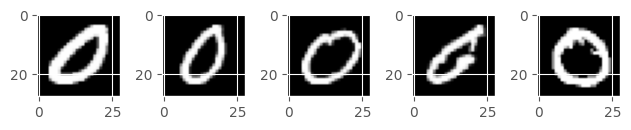

Tipo: 1


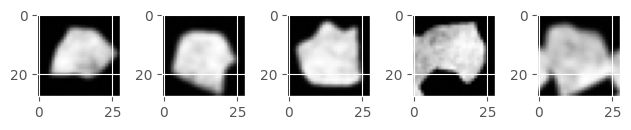

Tipo: 2


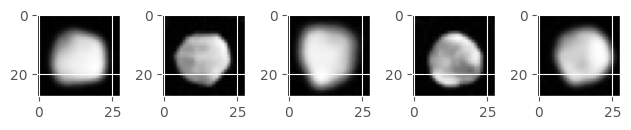

Tipo: 3


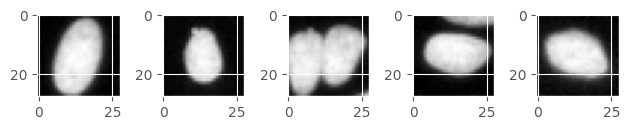

In [22]:
import random

# semilla para reproducible results
random.seed(1337)

# separar las células en diferentes tipos de mutación, manteniendo los índices
no_mutation_i = [i for i, x in enumerate(all_labels) if x == 0]
m1_i = [i for i, x in enumerate(all_labels) if x == 1]
m2_i = [i for i, x in enumerate(all_labels) if x == 2]
m3_i = [i for i, x in enumerate(all_labels) if x == 3]
mutation_types = [no_mutation_i, m1_i, m2_i, m3_i]

# graficar 5 imagenes de cada tipo
sample_size = 5

for row, mutation_type in enumerate(mutation_types):
    print("Tipo: {}".format(row))
    sample = random.sample(mutation_type, sample_size)
    for i, x in enumerate(sample):
        img = all_imgs[x]
        img = img.reshape((28, 28))
        plt.subplot(row +1, sample_size, 1 + i)
        plt.imshow(img, cmap="Greys")
    plt.tight_layout()
    plt.show()

Esto debería brindarle una comprensión intuitiva de lo que el algoritmo de aprendizaje automático necesita aprender para que pueda distinguir entre los diferentes tipos de celdas. Incluso como no expertos, podemos ver que los tipos de mutación parecen bastante distintos entre sí, por lo que no debería ser demasiado difícil para un clasificador diferenciarlos.

### Preprocesando la data

Antes de comenzar a construir nuestros modelos, queremos dividir el conjunto de datos en un conjunto de prueba y train, y codificar las etiquetas en One Hot Encoding

### Ejercicio 2

Divida el conjunto de datos de modo que el 90 % de los datos se use para entrenamiento y el 10 % de los datos se reserve para pruebas. Debe "estratificar" aún más los datos para que la misma proporción de cada tipo de celda esté presente en los conjuntos de entrenamiento y prueba.

**Hint:** Podemos usar `stratify` en sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) :
        
```
label 0 in one-hot representation: [1 0 0 0]
label 1 in one-hot representation: [0 1 0 0]
label 2 in one-hot representation: [0 0 1 0]
label 3 in one-hot representation: [0 0 0 1]
```

In [57]:
np.unique(all_labels)

array([0., 1., 2., 3.])

In [23]:
# split el dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=13
)

no_of_different_labels = 4  #  i.e. 0, 1, 2, 3 mutations

train_imgs = X_train
test_imgs = X_test
train_labels = y_train
test_labels = y_test

In [24]:
X_train.shape,X_test.shape

((1080, 784), (120, 784))

In [25]:
y_train.shape, y_test.shape

((1080, 1), (120, 1))

In [26]:
lr = np.arange(no_of_different_labels)
# transformar en one-hot representation
train_labels_one_hot = (lr == train_labels).astype(float)
test_labels_one_hot = (lr == test_labels).astype(float)

In [28]:
train_labels_one_hot

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [20]:
train_labels_one_hot.shape,test_labels_one_hot.shape

((1080, 4), (120, 4))

In [21]:
image_size = 28  # width and length
image_pixels = image_size * image_size
print(image_pixels)
# Esto no es necesario, pero es útil si desea guardar sus datos y reutilizarlos en un momento posterior
## este código vuelca los datos en un archivo .pkl para facilitar la reutilización de los objetos de Python que hemos creado
'''
with open("data/pickled_dat.pkl", "bw") as fh:
    data = (train_imgs,
            test_imgs,
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)
'''
# image_size = 28  # width and length
# image_pixels = image_size * image_size

784


'\nwith open("data/pickled_dat.pkl", "bw") as fh:\n    data = (train_imgs,\n            test_imgs,\n            train_labels,\n            test_labels,\n            train_labels_one_hot,\n            test_labels_one_hot)\n    pickle.dump(data, fh)\n'

## Creando y entrenando la neural network

Ahora construyamos una red neuronal simple de una sola capa y de una sola época desde cero (usando solo `numpy` y `scikit-learn`) y entrenémosla usando las imágenes sin procesar. Para esto podemos usar l funcionalidad [`Sequential`](https://keras.io/guides/secuencial_model/) de [`keras`](https://keras.io/)). Usaremos más herramientas listas para usar más adelante en este caso, pero para asegurarse de que comprende cómo funcionan las redes neuronales, es bueno que construya una simple usted mismo.

Construiremos una red neuronal muy básica desde cero en la clase `NeuralNetwork`. Puede encontrar un código de esqueleto para esta clase a continuación.



```
class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        ...
        
    def train(self, input_vector, target_vector):
        ...
        
    def run(self, input_vector):
        return ...
            
    def confusion_matrix(self, data_array, labels):
        return ...
    
    def evaluate(self, data, labels):
        return ...
```



También agregaremos las funciones `precisión` y `recall` para mayor comodidad.

Para redes neuronales completamente conectadas, hay tres preguntas esenciales que definen la **arquitectura** de la red:

1. ¿Cuántas capas hay?
1. ¿Cuántos nodos hay en cada una de esas capas?
1. ¿Qué función de activación se usa en cada una de esas capas?

Recuerde que existe una función de activación (generalmente la función de regresión logística) entre cada par de capas, lo que permite que nuestra red desarrolle sensibilidades no lineales. Cuando hay varias capas, podemos seguir agregando más combinaciones lineales de los nodos, lo que conducirá a modelos no lineales más complejos. Ya vimos la función de activación no lineal simple *ReLu*. En este caso, también usaremos la *función sigmoide* como función de activación, pero lo más importante que debe recordar es que hay [muchas funciones de activacion](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/) y la estructura y las restricciones de su problema lo guiarán con respecto a cuál es mejor usar. Por ejemplo, la tarea de clasificación de imágenes en cuestión hace que ReLU sea una buena opción para nosotros debido a su eficiencia.

### Ejercicio 3

Escribir las funciones de activacion `sigmoid` y `relu`

```
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return ???

def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return ???
```

In [31]:
@np.vectorize
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return 1 / (1 + np.e ** -x)

@np.vectorize
def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return np.maximum(x, 0)

Observe el símbolo `@` en la solución: esto indica que la función que sigue es un decorador de Python, que puede hacer que los cambios de función sean más fáciles de implementar y más legibles. Puede obtener más información [aquí] (https://stackoverflow.com/questions/19844177/what-does-the-symbol-do-in-ipython-python). Ahora, grafiquemos las funciones de activación para que podamos examinar sus diferencias visualmente. La función ReLu debería resultarle familiar:


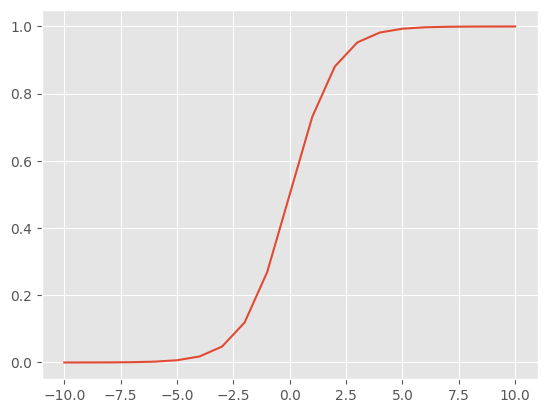

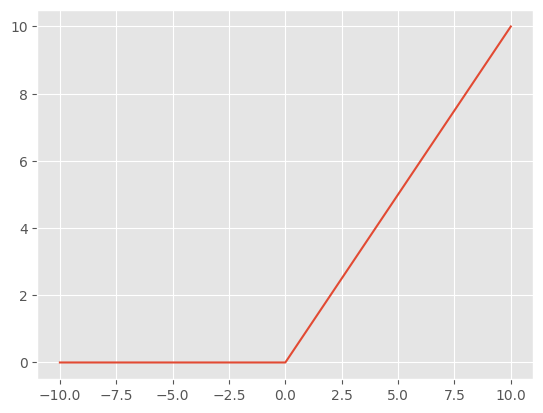

In [32]:
def plot_activation_function(activation_function):
    """
    Plots the given activation_function
    for the domain (-10, 10).
    """
    # define a series of inputs
    series_in = [x for x in range(-10, 11)]
    # calculate outputs for our inputs
    series_out = [activation_function(x) for x in series_in]
    # line plot of raw inputs to rectified outputs
    plt.plot(series_in, series_out)
    plt.show()
    
plot_activation_function(sigmoid)
plot_activation_function(relu)

Una parte crucial de nuestra clase `NeuralNetwork` son los parámetros de red, `weight_matrices`. Nuestra función `train` debe aprender cuál es el contenido de estas matrices de peso, y la función `run` aplicará esos pesos a la nueva entrada (por ejemplo, datos de prueba). Si tiene inclinaciones matemáticas, aquí hay algunas notaciones para ayudarlo a comprender cómo se actualizan los valores de los nodos con pesos y funciones de activación.


En la layer $\ell$ de la network, para $\ell = 1, \ldots, L$, definimos:

* $n_\ell$ number of nodes in the layer
* $W_\ell$ weight matrix
* $W_{\ell,jk}$ weight from node $j$ in layer $\ell-1$ to node $k$ in layer $\ell$
* $a_\ell$ the activation vector, where $a_{\ell,j}$ is the activation produced by node $j$ in layer $\ell$
* $a_0$ input vector
* $b_\ell$ bias 

Denotamos $z_\ell = W_\ell^T a_{\ell-1} + b_\ell$ por conveniencia. 

En la neural network, tenemos las siguiente relacion de recurrencia:

$$a_\ell = \phi(W_\ell^T a_{\ell-1} + b_\ell) = \phi(z_\ell),$$

$$a_0 = x,$$

Para las capas $\ell = 1, \ldots, L$. 

ie: La activacion $a_\ell$ en la layer $\ell$ es la suma del dot product de los weights con las activaciones de las layers anteriores $a_{\ell-1}$ y el parametro de bias. 

Esto lo ayudará más adelante a llenar los espacios en el código esqueleto. Tenga en cuenta que el parámetro de sesgo se puede ignorar por simplicidad. Puedes leer más sobre ellos [here](https://medium.com/deeper-learning/glossary-of-deep-learning-bias-cf49d9c895e2).)

### Ejercicio 4

A estas alturas, debería tener la mayoría de las piezas que necesita para construir su propia red neuronal desde cero. Intente completar el código de esqueleto para `class NeuralNetwork` proporcionado anteriormente. Si necesita ayuda, consulte los ejemplos proporcionados [aquí](https://www.python-course.eu/neural_network_mnist.php).


In [61]:
activation_function = sigmoid

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


class NeuralNetwork:
    def __init__(
        self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate
    ):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes))

    def train(self, input_vector, target_vector):
        """
        method to train the neural network on input_vector
        with output being target_vector
        """
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network

        # update the weights:
        tmp = output_errors * output_network * (1.0 - output_network)
        tmp = self.learning_rate * np.dot(tmp, output_hidden.T)
        self.who += tmp

        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        self.wih += self.learning_rate * np.dot(tmp, input_vector.T)

    def run(self, input_vector):
        """
        method to run (trained) neural network on input_vector
        using the weight matrices learned
        """
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((4, 4), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()

    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

## Usando la red


### Ejercicio 5

#### 5.1 

Cree una instancia de la red, entrénela en el conjunto de datos de entrenamiento (mostrando cada ejemplo de entrenamiento solo una vez) y haga que prediga la etiqueta para cada uno de los primeros 10 ejemplos en el conjunto de datos de prueba, así como la confianza de la predicción. Utilice valores apropiados para la tasa de aprendizaje y la cantidad de nodos ocultos según su experiencia en casos anteriores.

In [25]:
image_pixels

784

In [62]:
ANN = NeuralNetwork(
    no_of_in_nodes=image_pixels,
    no_of_out_nodes=4,  # numero de labels
    no_of_hidden_nodes=128,
    learning_rate=0.01,
)

In [63]:
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

print("true | pred |  P()")
print("_____________________")
for i in range(10):
    res = ANN.run(test_imgs[i])
    print(
        " ",
        int(test_labels[i][0]),
        " | ",
        np.argmax(res),
        "  | ",
        round(np.max(res), 3),
    )

true | pred |  P()
_____________________
  2  |  3   |  0.418
  3  |  3   |  0.542
  2  |  3   |  0.449
  0  |  0   |  0.955
  3  |  3   |  0.527
  2  |  3   |  0.38
  2  |  2   |  0.339
  2  |  3   |  0.391
  0  |  0   |  0.917
  1  |  2   |  0.339


#### 5.2 

Ahora evalúe la red en el train y pruebe los conjuntos de datos e imprima una matriz de confusión. Describa sus resultados.

In [64]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy en train: ", round(corrects / (corrects + wrongs), 3))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy en test:  ", round(corrects / (corrects + wrongs), 3))

print("")
print("confusion matrix:")
cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

print("")
for i in range(4):
    print(
        "mutant " + str(i) + ",",
        "precision: ",
        round(ANN.precision(i, cm), 2),
        " recall: ",
        round(ANN.recall(i, cm), 2),
    )

accuracy en train:  0.583
accuracy en test:   0.567

confusion matrix:
[[270   0   0   0]
 [  0   0   0   0]
 [  0  86  90   0]
 [  0 184 180 270]]

mutant 0, precision:  1.0  recall:  1.0
mutant 1, precision:  0.0  recall:  nan
mutant 2, precision:  0.33  recall:  0.51
mutant 3, precision:  1.0  recall:  0.43


Vemos que la red identifica fácilmente los casos sin mutación pero que tiene más dificultad para distinguir entre las distintas mutaciones. Tenga en cuenta que la red tiene problemas particulares con la mutación 1. En general, obtenemos una precisión de alrededor del 60 % tanto para los conjuntos de datos de prueba como para los de entrenamiento. Dado que la precisión de referencia sería del 25 % (ya que tenemos cuatro clases), este es un resultado razonablemente bueno, pero esperábamos que fuera mayor, especialmente para el conjunto de datos de entrenamiento, dado que la tarea no parecía demasiado difícil.

#### 5.3 

Las redes neuronales se benefician de ver ejemplos más de una vez durante varias épocas. Vuelva a entrenar la red, pero esta vez durante 30 épocas, y vea si los resultados son mejores. Una vez más, describe tus resultados.

**Sugerencia:** La red neuronal que construimos no tiene la función de época incorporada, pero puede ejecutar un ciclo `for` simple para mostrar el conjunto de datos muchas veces. Debe generar el train y probar la precisión después de cada época.

In [65]:
epochs = 30
train_acc=[]
test_acc=[]
for epoch in range(epochs):
    print("epoch:", epoch)
    for i in range(len(train_imgs)):
        ANN.train(train_imgs[i], train_labels_one_hot[i])

    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy en train: ", round(corrects / (corrects + wrongs), 3))
    train_acc.append(round(corrects / (corrects + wrongs), 3))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy en test:  ", round(corrects / (corrects + wrongs), 3))
    test_acc.append(round(corrects / (corrects + wrongs), 3))

epoch: 0
accuracy en train:  0.719
accuracy en test:   0.708
epoch: 1
accuracy en train:  0.734
accuracy en test:   0.717
epoch: 2
accuracy en train:  0.739
accuracy en test:   0.733
epoch: 3
accuracy en train:  0.74
accuracy en test:   0.733
epoch: 4
accuracy en train:  0.746
accuracy en test:   0.733
epoch: 5
accuracy en train:  0.764
accuracy en test:   0.75
epoch: 6
accuracy en train:  0.781
accuracy en test:   0.758
epoch: 7
accuracy en train:  0.798
accuracy en test:   0.758
epoch: 8
accuracy en train:  0.805
accuracy en test:   0.733
epoch: 9
accuracy en train:  0.81
accuracy en test:   0.758
epoch: 10
accuracy en train:  0.818
accuracy en test:   0.758
epoch: 11
accuracy en train:  0.819
accuracy en test:   0.767
epoch: 12
accuracy en train:  0.828
accuracy en test:   0.775
epoch: 13
accuracy en train:  0.836
accuracy en test:   0.783
epoch: 14
accuracy en train:  0.842
accuracy en test:   0.792
epoch: 15
accuracy en train:  0.845
accuracy en test:   0.792
epoch: 16
accuracy en

Text(0, 0.5, 'Accuracy')

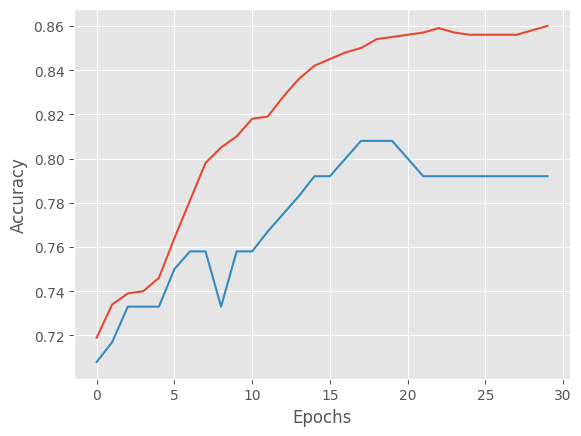

In [66]:
import matplotlib.pyplot as plt 
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Con más épocas, la red neuronal comienza a funcionar mejor. Si bien la precisión del conjunto de entrenamiento sigue mejorando en este punto, ya que la red neuronal comienza a "memorizar" el conjunto de entrenamiento, la precisión de la prueba no parece mejorar por encima del 80 %, aunque sigue siendo significativamente mejor que nuestro resultado anterior.

## Construcción y entrenamiento de una red neuronal convolucional

Hay muchos factores que pueden contribuir al rendimiento de una red neuronal. Como se discutió en casos anteriores, estos incluyen qué función de pérdida se usa (usaremos [**entropía cruzada categórica**](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)), qué algoritmo de optimización se usa (usaremos [**descenso de gradiente estocástico**](https://keras.io/api/optimizers/sgd/)), cuántas épocas de entrenamiento ejecutar antes de detenerse y el tamaño del lote dentro de cada época. El rendimiento también está influenciado por la cantidad de capas ocultas.

Es posible que las redes neuronales normales no se adapten bien a las imágenes completas. En nuestro conjunto de datos de celdas, las imágenes originalmente tenían un tamaño de 200x200x3 (200 de ancho, 200 de alto, 3 canales de color RGB), por lo que una sola neurona completamente conectada en la primera capa oculta de una red neuronal normal tendría 200x200x3 = 120 000 pesos. Esto es inmanejable; además, nos gustaría tener más de una sola neurona en nuestra red. Esta gran cantidad de parámetros conduciría a un sobreajuste, por lo que redujimos las imágenes a 28x28x1 para hacer factible una estructura completamente conectada. Recuerde que también aplanamos nuestras imágenes de entrada a un solo vector de longitud 784. Esto no es ideal ya que ofuscamos la información sobre qué píxeles están uno al lado del otro.

### Entendiendo las CNN

**Convolutional neural networks (CNN)** aprovechan el hecho de que la entrada consta de imágenes, cuyas propiedades espaciales restringen naturalmente la arquitectura para mantener manejable la cantidad de parámetros. En particular, a diferencia de una red neuronal regular, las capas de una CNN tienen neuronas dispuestas en 3 dimensiones: ancho, alto y profundidad. (Tenga en cuenta que la palabra profundidad aquí no se refiere al número total de capas en una red). Por ejemplo, nuestras imágenes de entrada originales tenían unas dimensiones de 200x200x3 (ancho, alto, profundidad respectivamente), donde la profundidad se refiere a los 3 colores RGB canales Las neuronas de una capa solo se conectarán a una pequeña región de la capa anterior, en lugar de a todas las neuronas. Gráficamente, las CNN se representan comúnmente mediante prismas rectangulares para mostrar que las neuronas están dispuestas en 3 dimensiones:

<img src=files/ann_v_cnn.png width="800">

A la izquierda, tenemos una red neuronal regular de 3 capas. A la derecha, tenemos una red neuronal convolucional. Una CNN organiza sus neuronas en tres dimensiones (ancho, alto, profundidad) como se visualiza en una de las capas. Cada capa de una CNN transforma el volumen de entrada 3D en un volumen de salida 3D de activaciones neuronales. En este ejemplo, la capa de entrada roja contiene la imagen, por lo que su ancho y alto serían las dimensiones de la imagen, y la profundidad sería 3 (p. ej., canales rojo, verde, azul si se utilizan imágenes en color con codificación RGB estándar).


Ahora que hemos visto la implementación de una red neuronal simple completamente conectada, podemos construir una red más avanzada utilizando un paquete de software existente. Usaremos la funcionalidad `Sequential` incorporada de la biblioteca `keras` de Python para construir una red más avanzada.

Para determinar los hiperparámetros correctos para nuestra red neuronal, necesitaremos volver a ejecutar nuestra red neuronal con diferentes parámetros varias veces. Es útil si configuramos un pipeline para facilitar este proceso. Aquí, creamos las funciones `load_dataset` y `prep_pixels` para facilitar la carga y preparación de los datos que necesitamos para el entrenamiento:

## Voy por aqui

In [33]:
# Cargar data
def load_dataset():
    all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))
    # primera columna son los labels
    all_imgs = np.asfarray(all_dat[:, 1:])
    all_labels = np.asfarray(all_dat[:, :1])

    # split en train:test
    trainX, testX, trainY, testY = train_test_split(
        all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=13
    )
    # reshape el dataset para tener un solo channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode los target
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


# scalar pixels
def prep_pixels(train, test):
    # convertir de int afloats
    train_norm = train.astype("float32")
    test_norm = test.astype("float32")
    # normalizar en el range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # retornar las imagenes normalizadas
    return train_norm, test_norm

Antes de comenzar a definir nuestra arquitectura de red neuronal, asegúrese de estar familiarizado con estos términos y parámetros clave. Debe estar familiarizado con algunos de ellos del caso anterior:

1. **optimizador**: el algoritmo de optimización utilizado para actualizar los pesos en el entrenamiento de redes neuronales. Un optimizador común es el descenso de gradiente estocástico (SGD).
1. **tasa de aprendizaje**: La influencia del gradiente en la actualización de los pesos de la red neuronal en cada paso. Los valores más pequeños corresponden a actualizaciones más pequeñas (más lentas); el valor predeterminado en `SGD` de `keras` es 0.01.
1. **impulso (momentum)**: La influencia del cambio de peso del paso anterior en el siguiente peso; el valor predeterminado en `SGD` de `keras` es 0.0.
1. **función de pérdida**: la función que determina cómo evaluar las predicciones del modelo contra los datos etiquetados. Una función de pérdida común es [error cuadrático medio] (https://keras.io/api/losses/regression_losses/#mean_squared_error-function).

Sabemos que las CNN consisten en una pila de capas que detectan patrones cada vez más complejos, seguidas al final por un puñado de capas totalmente conectadas (Fully connected layers) que usan esos patrones para producir una decisión final:

<img src=files/conv_layers.png width="500">

Lo tome de [Towards Data Science](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2).

En las CNN, las capas alternas de **convolución** y **pooling** sirven para extraer características de una imagen, comenzando con formas básicas (como líneas en orientaciones particulares) y luego expandiéndose a combinaciones complicadas de estas formas básicas. Al final, las fully connected layers permiten que la red decida una categoría de clasificación basada en las características que han sido extraídas por capas anteriores.

Los diagramas de CNN mostrarán cómo la imagen original se vuelve progresivamente más estrecha y más profunda, a medida que una capa se enrosca en varios núcleos (expandiendo la profundidad) en una **capa de convolución** y luego se comprime en una **capa de pooling** (reduciendo la ancho). Lo que comienza como una imagen ancha con todos los píxeles originales se convierte en una capa profunda de características con menos información espacial. Entonces, ¿qué está sucediendo en estas capas de convolución cruciales?

Una **convolución** es una operación que extrae patrones de una imagen (también usamos la palabra para hablar sobre el resultado de tal operación). Has visto cómo una imagen puede representarse como una gran matriz de números. Una convolución consiste en pasar una matriz más pequeña, llamada **filtro convolucional** (o **núcleo (kernel)**), sobre esta matriz. El filtro extrae características de la matriz grande. En cada ubicación, cada píxel del filtro se multiplica por el píxel correspondiente de la imagen y los resultados se suman para producir un solo número, que se almacena en una nueva matriz llamada mapa de características. Esto es todo lo que necesitamos para comenzar a detectar bordes, líneas de orientaciones particulares y características más complejas.

Aquí hay una demostración de cómo se aplica el filtro, donde la pequeña matriz amarilla es el filtro, la matriz verde es la entrada y la matriz rosa es el mapa de características producido por la convolución:

<img src=files/convolution_schematic.gif width="400">

Lo tome de [WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/).

Las características que extrae un filtro dependen de los valores contenidos dentro de ese filtro. Confiamos en esto en nuestra CNN, ya que el proceso de entrenamiento ajusta los valores del filtro, que a su vez ajusta qué funciones se extraen. La operación de convolución combina la entrada y el filtro para producir una salida modificada (el mapa de características). Para obtener más información, consulte [esto] (http://datahacker.rs/edge-detection/).

Demostremos un ejemplo simple de cómo un filtro de convolución podría cambiar una imagen: aplicamos dos filtros diferentes de 4 x 4. Observa como el primero desenfoca la imagen mientras que el segundo resalta los bordes superior e inferior:

(28, 28)
(28, 28)


(-0.5, 27.5, 27.5, -0.5)

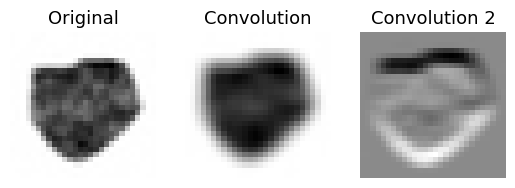

In [41]:
import scipy.ndimage as nd

# sElegimos una imagen al azar
img = all_imgs[400].reshape(28, 28)

conv_filter = np.array([[1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1]])
conv_filter2 = np.array([[1,1,1,1], [0,0,0,0], [0,0,0,0], [-1,-1,-1,-1]])

image_new = nd.convolve(img, conv_filter)
print(image_new.shape)
image_new2 = nd.convolve(img, conv_filter2)
print(image_new2.shape)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title("Original", fontsize=13)
axes[0].axis("off")

axes[1].imshow(image_new, cmap=plt.cm.gray)
axes[1].set_title("Convolution", fontsize=13)
axes[1].axis("off")

axes[2].imshow(image_new2, cmap=plt.cm.gray)
axes[2].set_title("Convolution 2", fontsize=13)
axes[2].axis("off")


Una vez que hemos detectado varias características, en realidad no nos importa su ubicación precisa en la imagen. Queremos conservar cierta información espacial, pero nos importa más la presencia o ausencia de una característica y su ubicación *relativa* a otras.

Una forma de deshacerse de toda esa información espacial adicional es **agrupar (pool)** la capa. Esto significa dividir la capa en cuadrados que no se superponen y realizar una operación que los agregue. La operación más común es simplemente generar el valor máximo encontrado dentro de esa región. Esto convierte una matriz grande en una matriz mucho más pequeña con los valores máximos de la anterior.

Al reducir la información espacial, tenemos menos cálculos que realizar y menos parámetros que podrían conducir a un sobreajuste. Cada paso de agrupación hace que la imagen sea más estrecha, al tiempo que conserva la profundidad:

<img src="files/conv_vs_pool.gif" width="500"/>

Lo tome de [Becoming Human](https://becominghuman.ai/what-exactly-does-cnn-see-4d436d8e6e52).

Keras provee las herramientas para hacer el pooling operation - mira [aqui](https://keras.io/api/layers/pooling_layers/). 

### Ejercicio 6

Escriba una función `define_model()` que use Keras para crear un modelo `Sequential` con una capa convolucional. Keras proporciona [capas convolucionales](https://keras.io/api/layers/convolution_layers/) en varias dimensiones (por ejemplo, 1D, 2D, 3D) y debe elegir una adecuada para la tarea.

**Pista:** Piensa en cuántas dimensiones tienen nuestras imágenes en escala de grises.

Debe intentar hacer esto sin ayuda, pero si necesita ayuda, puede consultar el código proporcionado [aquí] (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to -classify-satellite-photos-of-the-amazon-rainforest/) para obtener ayuda.

**Sugerencia:** Piensa en la forma de los datos. Deberá pasar la `input_shape` adecuada a la capa convolucional en función del tamaño de la imagen y terminar con una capa densa relacionada con las dimensiones de las etiquetas.

In [44]:
# definir el cnn model
def define_model():
    model = Sequential()
    model.add(
        Conv2D(
            8,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(9, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(4, activation="softmax"))
    
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.0)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

1. Se agrega una capa Conv2D al modelo con 8 filtros, una función de activación ReLU y una inicialización de pesos llamada "he_uniform". La capa de convolución se aplica a datos de entrada con una forma de (28, 28, 1), lo que significa que se espera una imagen en escala de grises de 28x28 píxeles. Usa 8 filtros y kernel 3x3
2. Se agrega una capa MaxPooling2D al modelo con un tamaño de ventana de (2, 2), lo que reduce a la mitad la dimensión espacial de la salida de la capa anterior.
3. Se agrega una capa Flatten al modelo, que aplanará los datos de salida de la capa anterior en un vector unidimensional antes de pasarlos a las capas completamente conectadas.
4. Se agrega una capa Dense al modelo con 9 neuronas, una función de activación ReLU y una inicialización de pesos llamada "he_uniform".
5. Se agrega una capa Dense final al modelo con 4 neuronas y una función de activación softmax. Esta capa se utiliza para la clasificación y producirá las probabilidades de pertenecer a cada una de las 4 clases posibles.
6. Se compila el modelo utilizando el optimizador SGD con una tasa de aprendizaje de 0.01 y un momento de 0.0. La función de pérdida utilizada es la entropía cruzada categórica y se utiliza la métrica de precisión para evaluar el rendimiento del modelo durante el entrenamiento.

Tómese un momento para revisar el material sobre convolución, agrupación y las partes del código en `define_model`. Luego responda las siguientes preguntas para verificar su comprensión:

### Pregunta

en tus propias palabras describe **learning rate** y **momentum** y como elegir estos valores

La **tasa de aprendizaje** es un pequeño número positivo que controla la rapidez con la que el modelo se adapta a los errores en cada iteración de entrenamiento. Los valores más grandes pueden ser ventajosos porque el aprendizaje ocurre "más rápido", pero también puede significar que el entrenamiento terminó con pesos inestables o subóptimos. Los valores más pequeños pueden ser ventajosos porque el aprendizaje es más preciso, pero también pueden significar que el entrenamiento lleva mucho más tiempo (o no se entrena por completo). Desea probar diferentes valores de la tasa de aprendizaje para ver cuál funciona mejor para su problema. Puede leer más sobre esto [aquí] (https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

El **impulso** es un hiperparámetro que controla cuánto se ven afectados los pesos del modelo por los pesos de la iteración anterior. El cambio de peso es igual a la tasa de aprendizaje multiplicada por el gradiente, más un factor de impulso multiplicado por el cambio de peso de la iteración anterior.


### Agregando funciones de ayuda

Para evaluar y comprender mejor nuestra red neuronal, necesitaremos usar algunas funciones más.

Hay cierta aleatoriedad involucrada en el proceso de entrenamiento y este es un conjunto de datos pequeño, por lo que algunas ejecuciones pueden mostrar resultados más altos o más bajos y la media de una sola ejecución debe tomarse con pinzas. Por este motivo, tenga en cuenta que ``evaluate_model`` utiliza $k$-fold [validación cruzada](https://scikit-learn.org/stable/modules/cross_validation.html) para garantizar que los resultados evaluados sean independiente del conjunto de prueba, dividiendo el conjunto de datos en $k$ conjuntos y manteniendo uno como conjunto de prueba en cada iteración, entrenando en el resto. [StratifiedKfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) asegura que las diferentes clases estén representadas proporcionalmente en cada conjunto:

In [45]:
# evaluar el modelo usando k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # preparar cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerar los splits
    dataY_asfactor = [
        np.argmax(y) for y in dataY
    ]  # StratifiedKFold no le interesa el one-hot encoded
    for train_ix, test_ix in kfold.split(dataX, dataY_asfactor):
        # definir model
        model = define_model()
        # elegir filas de train y test
        trainX, trainY, testX, testY = (
            dataX[train_ix],
            dataY[train_ix],
            dataX[test_ix],
            dataY[test_ix],
        )
        # fit el model
        history = model.fit(
            trainX,
            trainY,
            batch_size=3,
            epochs=30,
            validation_data=(testX, testY),
            verbose=False,
        )
        # evaluar el model
        #y_pred = model.predict_classes(testX, verbose=False)
        y_pred = model.predict(testX, verbose=False)
        y_true = [np.argmax(y) for y in testY]
        # print(confusion_matrix(y_true, y_pred))
        _, acc = model.evaluate(testX, testY, verbose=True)
        print("> %.3f" % (acc * 100.0))
        # store scores
        scores.append(acc)
        histories.append(history)
    print("")
    print(model.summary())
    print("")
    return scores, histories

In [46]:
# plot las graficar de diagnostico de aprendizaej
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title("Crossentropy Loss")
        plt.plot(histories[i].history["loss"], color="blue", label="train")
        plt.plot(histories[i].history["val_loss"], color="orange", label="test")
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title("Classification Accuracy")
        plt.plot(histories[i].history["accuracy"], color="blue", label="train")
        plt.plot(histories[i].history["val_accuracy"], color="orange", label="test")
        plt.tight_layout()
    plt.show()

In [47]:
# sumarizar el model performance
def summarize_performance(scores):
    # print summary
    print("")
    print(
        "Accuracy: mean=%.3f, std=%.3f, n=%d"
        % (mean(scores) * 100, std(scores) * 100, len(scores))
    )
    # box y whisker plots de resultados
    plt.boxplot(scores)
    plt.show()

In [48]:
# Ejecutar las pruebas
def run_test_harness(prep_pixels=False):
    # cargar
    trainX, trainY, testX, testY = load_dataset()
    # preparar la pixel data
    if prep_pixels:
        trainX, testX = prep_pixels(trainX, testX)
    # evaluar el model
    scores, histories = evaluate_model(trainX, trainY, n_folds=10)
    print(scores)
    # learning curves
    summarize_diagnostics(histories)
    # sumarizar el performance estimado
    summarize_performance(scores)

Con estos, ahora podemos ejecutar nuestro pipeline para el modelo completa, incluida la carga del conjunto de datos, el entrenamiento y la evaluación del modelo, y el resumen de los resultados, ejecutando la función `run_test_harness`.

### Ejercicio 7

Correr el pipeline completo y describir los resultados





4/4 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9444
> 94.444
4/4 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.8889
> 88.889
4/4 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.8426
> 84.259
4/4 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9074
> 90.741
4/4 [==============================] - 0s 2ms/step - loss: 0.3867 - accuracy: 0.7407
> 74.074
4/4 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.8889
> 88.889
4/4 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.9352
> 93.519
4/4 [==============================] - 0s 3ms/step - loss: 0.1776 - accuracy: 0.9444
> 94.444
4/4 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.7963
> 79.630
4/4 [==============================] - 0s 2ms/step - loss: 0.3613 - accuracy: 0.7500
> 75.000

Model: "sequential_9"
_________________________________

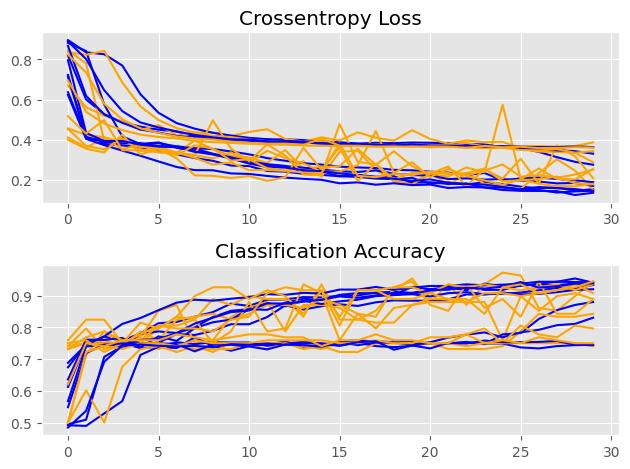


Accuracy: mean=86.389, std=7.373, n=10


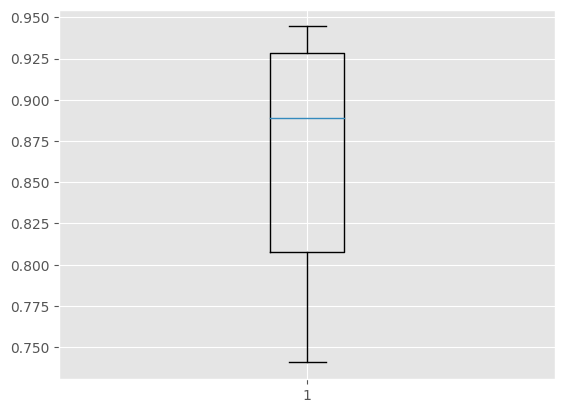

In [49]:
import warnings
warnings.filterwarnings("ignore")
run_test_harness()

El entrenamiento es bastante inestable, con una precisión en el conjunto de entrenamiento que va desde un 50 % hasta un 96 % durante el proceso. Tampoco mostró una mejora constante con cada época, sino que subió y bajó de una época a otra.

Sin embargo, la precisión de la prueba final es mejor que la que logramos con nuestra red anterior.

### Ejercicio 8

Para mejorar el rendimiento de nuestro modelo, podríamos intentar modificar los hiperparámetros, como la tasa de aprendizaje. También podríamos intentar agregar más capas.

Modifique la función `define_model()` para intentar mejorar el modelo. Al menos debería intentar agregar más capas convolucionales.

Describe tus resultados y compáralos con los anteriores.

In [50]:
# definir el nuevo cnn model
def define_model():
    model = Sequential()
    model.add(
        Conv2D(
            8,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(4, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(Conv2D(2, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(4, activation="softmax"))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

1. Capa de convolución (Conv2D):

- Número de filtros: 8
- Tamaño del filtro: (3, 3)
- Función de activación: ReLU (Rectified Linear Unit)
- Inicialización de pesos: He uniform
- Tamaño de entrada: (28, 28, 1) (imágenes en escala de grises de 28x28 píxeles)
- Esta capa realiza la convolución de los filtros en la imagen de entrada y aplica la función de activación ReLU para introducir la no linealidad.

2. Capa de Max Pooling (MaxPooling2D):

- Tamaño del filtro: (2, 2)
- Esta capa reduce la dimensión espacial de las características de entrada seleccionando el valor máximo en cada región.

3. Capa de convolución (Conv2D):

- Número de filtros: 4
- Tamaño del filtro: (3, 3)
- Función de activación: ReLU
- Inicialización de pesos: He uniform
- Esta capa realiza otra convolución con filtros adicionales en las características extraídas por la capa anterior.

4. Capa de convolución (Conv2D):

- Número de filtros: 2
- Tamaño del filtro: (3, 3)
- Función de activación: ReLU
- Inicialización de pesos: He uniform
- Esta capa realiza otra convolución con filtros adicionales en las características extraídas por la capa anterior.

5. Capa de Max Pooling (MaxPooling2D):

- Tamaño del filtro: (2, 2)
- Esta capa reduce aún más la dimensión espacial de las características de entrada.

6. Capa de aplanamiento (Flatten):
Esta capa convierte las características bidimensionales en un vector unidimensional, preparándolas para la entrada a capas completamente conectadas.

7. Capa densa (Dense):

- Número de neuronas: 8
- Función de activación: ReLU
- Inicialización de pesos: He uniform
- Esta capa completamente conectada tiene 8 neuronas y utiliza la función de activación ReLU para introducir no linealidad.

8. Capa densa (Dense):

- Número de neuronas: 4
- Función de activación: Softmax
- Esta es la capa de salida que tiene 4 neuronas y utiliza la función de activación softmax para obtener probabilidades de pertenencia a cada una de las clases.

4/4 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8796
> 87.963
4/4 [==============================] - 0s 2ms/step - loss: 0.1663 - accuracy: 0.9352
> 93.519
4/4 [==============================] - 0s 3ms/step - loss: 0.4122 - accuracy: 0.8333
> 83.333
4/4 [==============================] - 0s 2ms/step - loss: 0.1534 - accuracy: 0.9352
> 93.519
4/4 [==============================] - 0s 2ms/step - loss: 0.8280 - accuracy: 0.5000
> 50.000
4/4 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.8426
> 84.259
4/4 [==============================] - 0s 3ms/step - loss: 0.3067 - accuracy: 0.9167
> 91.667
4/4 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.8148
> 81.481
4/4 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.8889
> 88.889
4/4 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.8056
> 80.556

Model: "sequential_19"
____________________________________

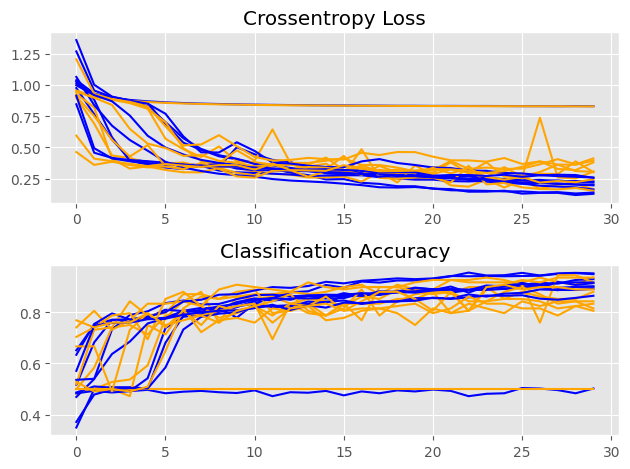


Accuracy: mean=83.519, std=12.050, n=10


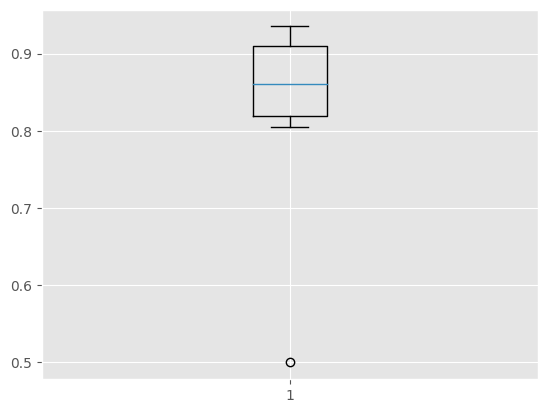

In [51]:
import warnings
warnings.filterwarnings("ignore")
run_test_harness()

Con las capas adicionales, el modelo tardó un poco más en entrenarse, pero ahora alcanzamos una precisión de alrededor del 89 %, que es mejor que nuestro modelo más simple y sustancialmente mejor que nuestro modelo base simplificado

## Uso de funciones extraídas previamente para entrenar algoritmos de aprendizaje automático más simples

Como podemos ver, trabajar con imágenes en bruto puede ser muy desafiante. Por un lado, las imágenes contienen una gran cantidad de datos (una sola imagen en nuestro conjunto de datos tiene 784 píxeles, y esta es una resolución bastante *baja*); por otro lado, las imágenes también contienen mucho ruido y redundancia (por ejemplo, altas correlaciones espaciales, efectos aleatorios de iluminación y desenfoque). A menudo, cuando se trabaja con datos que tienen una relación señal/ruido baja, es útil utilizar un enfoque de preprocesamiento más mecánico para transformar los datos en un subespacio que tiene una relación señal/ruido más alta. Estos pasos de preprocesamiento deben aplicar el conocimiento específico del dominio relevante a los datos para "concentrar" las partes clave de la señal. En nuestro ejemplo, los biólogos pueden examinar unas pocas docenas de imágenes y señalar las características relevantes de las imágenes para distinguir entre diferentes mutaciones:

1. "Las células normales tienen una forma más elíptica".
2. "La segunda mutación parece tener células generalmente más oscuras y densas".
3. "La primera mutación da como resultado células con bordes más irregulares".
4. "Esperaríamos que las células mutantes se agruparan más".

Cada una de estas observaciones humanas podría escribirse como una medida cuantitativa:

1. Forma
2. Color
3. Excentricidad
4. Proximidad

Los algoritmos de visión por computadora pueden traducir imágenes sin procesar en algunas de las características mencionadas en estas observaciones. Para nuestras imágenes, sabemos que hay un objeto de celda en el medio con un fondo oscuro. Separar una imagen en múltiples segmentos (con suerte relevantes) se conoce como **segmentación de imágenes**. Aquí hay un ejemplo de segmentación de imágenes para un automóvil autónomo:



<img src=files/self-driving-car.gif width="600">

Aquí hay un diagrama de cómo se incorpora la segmentación de imágenes en un pipeline de análisis celular:

<img src=files/cell_analysis_pipeline.png width="600">

El conjunto de datos que analizaremos en la siguiente parte del caso son 50 características extraídas automáticamente para cada celda en nuestro conjunto de datos de imágenes utilizando algoritmos de visión por computadora (personalizados para imágenes de células capturadas a través de microscopía fluorescente). Puede cargar el nuevo archivo CSV de la siguiente manera:

In [52]:
feature_dat = pd.read_csv("data/feature_dat.csv")
print(feature_dat.shape)
feature_dat.head()

(1200, 51)


,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,color1,color2,...,proxi2,proxi3,proxi4,proxi5,proxi6,proxi7,proxi8,hrlck1,hrlck2,mutation
0,-0.000002,-0.000006,0.000338,-6.223100e-06,5.723900e-05,0.000472,0.052716,0.052722,0.052383,0.095004,...,4.4449,0.836480,-1.5031,-1.5029,1.150963,1.670230,-1.4964,0.231260,4.662331,0
1,0.000023,0.000022,-0.000043,7.678700e-07,1.663000e-05,-0.000189,0.055287,0.055265,0.055308,0.071142,...,8.4147,1.839299,-1.5025,-1.5027,1.992683,2.807464,-1.5055,1.532233,5.196261,0
2,-0.000022,0.000004,0.000362,1.681700e-06,-1.189500e-05,-0.000167,0.006509,0.006505,0.006143,0.019397,...,5.7082,-0.575317,-1.4975,-1.4969,-1.057035,-1.575473,-1.4984,-1.846138,5.158199,0
3,0.000003,0.000005,0.000006,1.402100e-06,7.705300e-07,0.000008,0.059301,0.059296,0.059290,0.110130,...,2.8404,0.611047,-1.4967,-1.4967,1.118759,1.667009,-1.4972,1.995589,4.610642,0
4,-0.000008,-0.000049,0.000103,2.089200e-06,-9.886500e-05,-0.000121,0.010542,0.010591,0.010488,-0.020250,...,6.4415,1.607215,-1.5066,-1.5065,1.959528,2.804148,-1.4979,0.583515,4.916569,0


Este es un ejemplo de cómo una imagen se traduce en algunas de las características extraídas que ve en la tabla:

<img src=files/cell_extraction.png width="800">

### Entrenando un random forest classifier

Ahora construyamos y entrenemos clasificadores más simples en las características de ingeniería extraídas de las imágenes. Ahora que hemos transformado nuestras imágenes en un conjunto de datos más "clásico", podemos elegir un modelo de nuestro conjunto familiar de herramientas de clasificación.

### Ejercicio 9

Divida el nuevo conjunto de datos de la misma manera que el anterior. Utilice un [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) para escalar los datos y cree un [`RandomForestClassifier`](https: //scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), entrenado en estos datos escalados. Genere las matrices de precisión y confusión, así como la precisión y sensibilidad para cada tipo de celda. Describa los resultados.

In [44]:
# recolectar data
X = feature_dat.drop("mutation", axis=1)
Y = feature_dat.mutation

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=13
)

# escalar features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ajustar el random forest classifier
classifier = RandomForestClassifier(
    n_estimators=10, criterion="entropy", random_state=13
)
classifier.fit(X_train, y_train)

# hacer predicciones en training set
y_pred_train = classifier.predict(X_train)
print("accuracy train: ", round(np.mean(y_pred_train == y_train), 2))

# hacer las predicciones en test 
y_pred = classifier.predict(X_test)
print("accuracy test:  ", round(np.mean(y_pred == y_test), 2))

print("")
print("confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("")
for i in range(4):
    print(
        "mutant " + str(i) + ",",
        "precision: ",
        round(ANN.precision(i, cm), 2),
        " recall: ",
        round(ANN.recall(i, cm), 2),
    )

accuracy train:  1.0
accuracy test:   0.88

confusion matrix:
[[34  2  0  1]
 [ 1 18  2  0]
 [ 2  4 21  1]
 [ 0  1  0 33]]

mutant 0, precision:  0.92  recall:  0.92
mutant 1, precision:  0.72  recall:  0.86
mutant 2, precision:  0.91  recall:  0.75
mutant 3, precision:  0.94  recall:  0.97


Con una precisión del 88 %, el RF en la nueva representación de nuestros datos funciona tan bien como la CNN, y también es significativamente más rápido.

Esto demuestra que la ingeniería de funciones adecuada puede ser más importante que el uso de algoritmos avanzados. Las redes neuronales a menudo brillan para conjuntos de datos realmente grandes, mientras que los algoritmos más simples a menudo pueden funcionar tan bien o mejor en los más pequeños.

### Ejercicio 10
Usando el código anterior de una sola iteración del bosque aleatorio, escriba una función `evaluate_rfmodel` que sea muy similar a `evaluate_model` del arnés de prueba de la red neuronal. Cree un `StratifiedKFold` del conjunto de datos y ejecute múltiples iteraciones, creando un diagrama de caja para mostrar la precisión. Explique los resultados.

> 98.333
> 97.500
> 98.333
> 98.333
> 96.667
> 100.000
> 98.333
> 99.167
> 98.333
> 97.500

Accuracy: mean=98.250, std=0.870, n=10


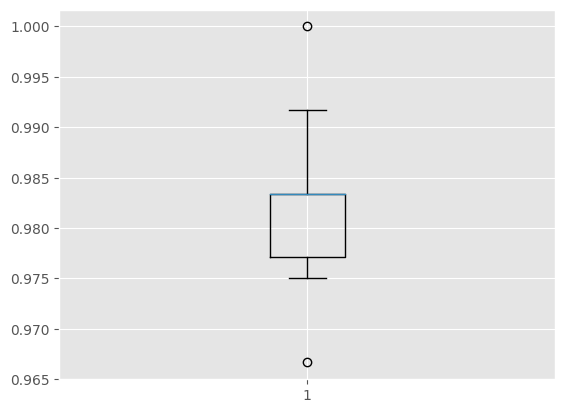

In [45]:
# evaluate random forest model using k-fold cross-validation
def evaluate_rfmodel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX, dataY):
        # define model
        model = RandomForestClassifier(
            n_estimators=10, criterion="entropy", random_state=13
        )
        # select rows for train and test
        trainX, trainY, testX, testY = (
            dataX[train_ix],
            dataY[train_ix],
            dataX[test_ix],
            dataY[test_ix],
        )
        # scale features
        scaler = StandardScaler()
        trainX = scaler.fit_transform(trainX)
        testX = scaler.transform(testX)
        # fit model
        history = model.fit(X_train, y_train)
        # evaluate model
        y_pred = model.predict(testX)
        y_true = testY
        # print(confusion_matrix(y_true, y_pred))
        acc = np.mean(y_pred == y_true)
        print("> %.3f" % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

scores, _ = evaluate_rfmodel(np.asarray(X), np.asarray(Y), n_folds=10)
summarize_performance(scores)

Con varias ejecuciones, podemos ver que el bosque aleatorio en realidad funciona mucho mejor que la CNN y también es más consistente.

## Consideraciones finales

En este caso, aprendimos sobre los desafíos de trabajar con datos de imágenes. Clasificar cientos de imágenes previamente limpiadas en cuatro categorías es una tarea relativamente estándar, pero aprendimos algunas lecciones importantes y también sobre otros desafíos que se manifiestan a medida que aumenta la complejidad. Si tenemos imágenes sin procesar, más imágenes, imágenes más grandes, más clases o más preguntas inferenciales (vs. predictivas), este problema puede volverse aún más complicado. Aquí hay algunos puntos importantes de nuestro caso de hoy:

1. **Preprocesamiento, preprocesamiento, preprocesamiento.** Pasará la mayor parte de su tiempo comprendiendo y luego procesando sus datos sin procesar. Esto puede ser tan simple como recortar sus imágenes o tan complejo como ajustar el color, el brillo, el desenfoque, etc. A menudo, se pueden lograr mejoras sustanciales en el rendimiento predictivo con un preprocesamiento más inteligente.
2. **Las redes neuronales pueden ser realmente útiles... a veces.** Nuestra comparación del rendimiento de la red neuronal con un clasificador de RF nos mostró que las redes neuronales no siempre tienen un rendimiento significativamente mejor. Es más inteligente comenzar con los modelos más simples que pueda y solo comenzar a usar redes neuronales si tiene grandes conjuntos de datos y relaciones altamente no lineales.
3. **Las redes neuronales convolucionales pueden ser útiles cuando se trabaja con datos de señales grandes** (p. ej., imagen, audio, video). Aprendimos que las CNN son un tipo de red neuronal especialmente adaptada para trabajar con datos de entrada que son muy grandes y tienen algún tipo de estructura de dependencia (por ejemplo, espacial). Al igual que cualquier otro modelo, no siempre son útiles y pueden tener un rendimiento muy bajo en las configuraciones incorrectas, pero pueden dar muy buenos resultados en las correctas.

También se le presentó una gran cantidad de código nuevo en las bibliotecas de aprendizaje profundo. Es demasiado para digerir, así que revise el material técnico en este caso nuevamente en su tiempo libre para familiarizarse realmente con la implementación de las CNN en la práctica.

### Apendice A: Una observación sobre las CNN con imágenes de entrada de diferentes dimensiones

En este caso, estaba trabajando con un conjunto de datos de imágenes preprocesadas, donde las imágenes ya estaban hechas para tener el mismo tamaño y dimensiones. En la vida real, es posible que le entreguen un conjunto de datos mucho más desordenado donde las imágenes no tienen las mismas dimensiones, resolución o tamaño. Limpiarlos y procesarlos puede consumir un valioso tiempo de ciencia de datos. Entonces, ¿esto importa?

### Pregunta extra:

¿Cuáles de los siguientes tipos de **capas** de redes neuronales son invariantes al tamaño de la imagen?

(a) completamente conectado

(b) convolucional

(c) agrupación máxima

(d) capas de normalización por lotes

**Respuesta.** Solo (a) **no** es invariable al tamaño de la imagen. Todos los demás tipos de capas mencionados anteriormente pueden aceptar imágenes de cualquier dimensión. Obtenga más información [aquí](https://ai.stackexchange.com/questions/6274/convolutional-neural-networks-with-input-images-of-different-dimensions-image).

### Apéndice B: un comentario sobre las bibliotecas de aprendizaje profundo

Como científico de datos, debe estar familiarizado con diferentes bibliotecas de aprendizaje profundo. PyTorch y Tensorflow son dos de los frameworks más populares. Keras inicialmente estaba separado de TensorFlow y proporciona un mayor nivel de abstracción para las arquitecturas de red comunes. Ahora se incluye como parte de TensorFlow, ya que es muy popular en la industria, donde el uso de algoritmos comprobados es más importante que el desarrollo de algoritmos novedosos.

<img src=files/keras_tensorflow_decision.png width="500">

### Apéndice C: un comentario sobre otras arquitecturas de redes neuronales

Existen docenas de otras arquitecturas (y algoritmos de aprendizaje correspondientes) para diferentes tipos de datos, preguntas y restricciones. No es necesario que los entienda todos, pero debe ser consciente de lo que hay:

<img src=files/chart_of_neural_networks.png width="700">

Lo tome de [Stack Exchange](https://ai.stackexchange.com/questions/5546/what-is-the-difference-between-a-convolutional-neural-network-and-a-regular-neur).